In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, dataloader
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from datagen import *
from analysis import *
from datagen2D import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()

Running on CPU


c:\Users\matti\anaconda3\envs\torch2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on CPU


## Dataset Testing

In [9]:
data,labels = smooth_wandering_2D(100,40,bound=1)


tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)
tensor(1330)

KeyboardInterrupt: 

In [5]:
data,labels = rat_box(1000,10)

100%|██████████| 1000/1000 [00:06<00:00, 158.28it/s]


In [13]:
# data, labels = smooth_wandering_2D_bing(n_data=100,t_steps=20,bound=0.5)
x,y,vx,vy = random_walk(40)

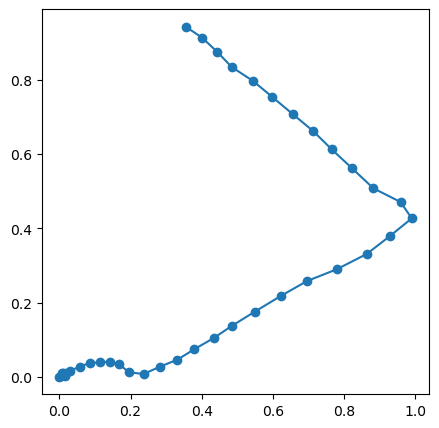

In [14]:
# Plot 2D wandering
plt.figure(figsize=(5,5))
plt.plot(x,y,'-o')
plt.show()

## Model

In [48]:
hidden_size = 128
input_size = 1
nav_size = 1

model1 = RNN_circular_LowEtAl_bridged(input_size,hidden_size,lr=0.0001,irnn=True,outputnn=False,Wx_normalize=False,activation=True,bias=False,nav_space=1,batch_size=64).to(device)
# model1 = torch.compile(model1)

train = False

if train:
    _ = model1.train_gradual(epochs=10000)
    # model1.base_training_tsteps = 40
    # _ = model1.train(epochs=10000)
    model1.plot_losses(average=30)
else:
    # model1.load_state_dict(torch.load("../trained models/LowEtAl_bridged_10000gradual+2000base.pt"))
    model1.load_state_dict(torch.load("../trained models/LowEtAl_bridged_10000gradual.pt",map_location=torch.device('cpu')))

# torch.save(model1.state_dict(), "../trained models/LowEtAl_bridged_reduced_Gradual_lossiequaloroverj_maskonangle_lossscale_4000gradual.pt")

100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

Losses array was not a multiple of average. Truncated to 0



c:\Users\matti\Dropbox\Jobb\BioAI\RNN-Adding-Problem-Representations\notebooks\../src\model.py:861: RuntimeWarning: Mean of empty slice.
  loss_data_avgd = losses.reshape(average,-1).mean(axis=1)
c:\Users\matti\anaconda3\envs\torch2\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\matti\Dropbox\Jobb\BioAI\RNN-Adding-Problem-Representations\notebooks\../src\model.py:862: RuntimeWarning: Mean of empty slice.
  loss_data_norm_avgd = losses_norm.reshape(average,-1).mean(axis=1)


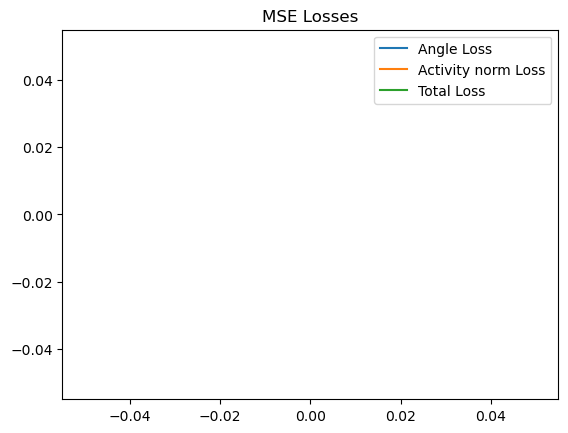

In [39]:
# model1.base_training_tsteps = 200
# _ = model1.train(epochs=1)
# model1.plot_losses(average=30)

In [4]:
# torch.save(model1.state_dict(), "../trained models/LowEtAl_bridged_10000gradual+2000base.pt")

## Analysis

### Norm of activity per timestep

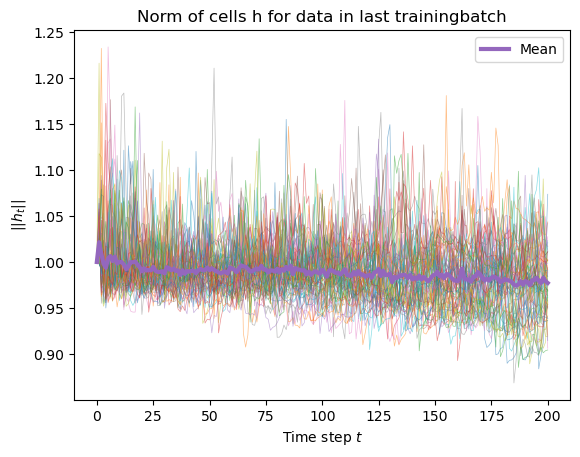

Mean norm:  0.9882548


In [40]:
htss = model1.hts.norm(dim=2)
htss = htss.cpu().detach().numpy()
plot_norm(htss,avg_only=False)

### Tuning curves

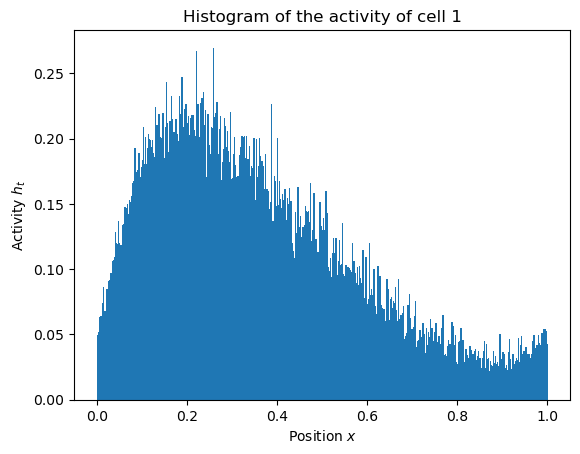

100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


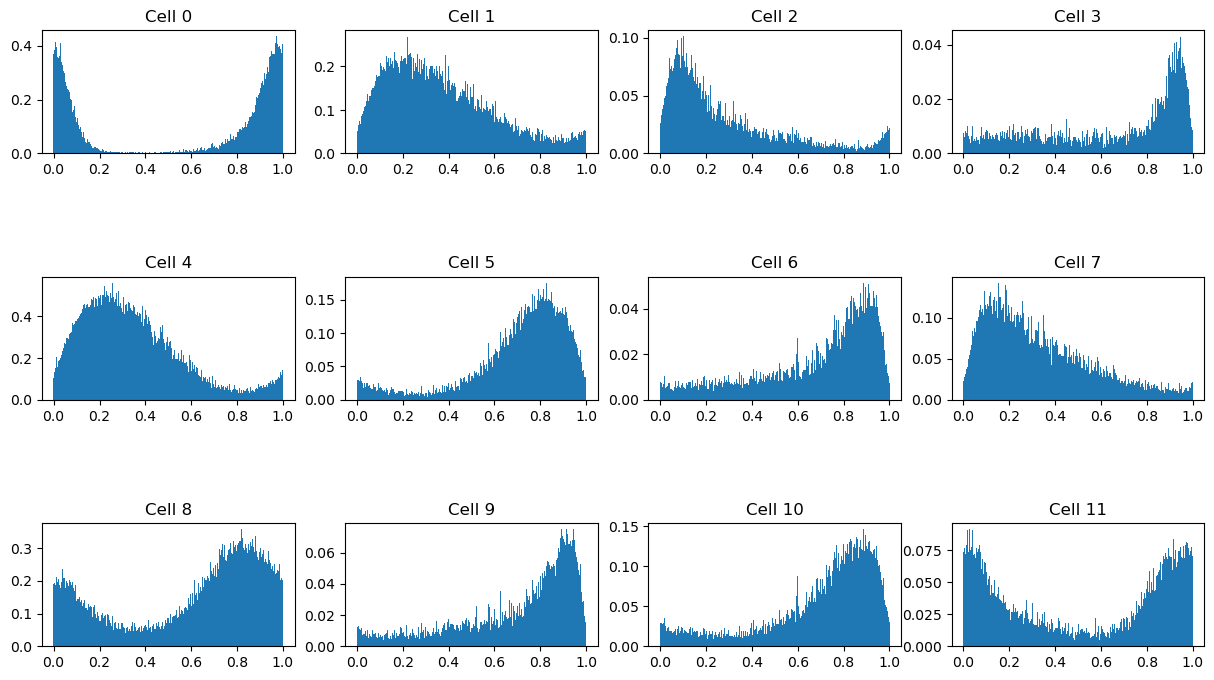

In [52]:
activity, bin_edges = tuning_curve(model1)
plot_tuning_curve(activity,bin_edges,1,spherical=False,linear=True,scale_to_one=True, plot_head_frac=1/10)

### Low dimensional representations

Explained variance for PCA with 2 components: 92.702 %


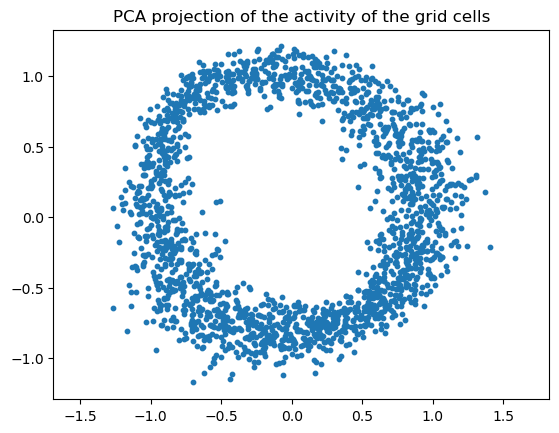

In [50]:
embedding, reducer = lowD_reduce(activity,if_pca=True,n_components=2,plot=True)

### Accuracy testing

In [45]:
angs, dy, err, y_hat, y = test_angle_inference(model1,reducer)


Mean error:  0.1136742334322957


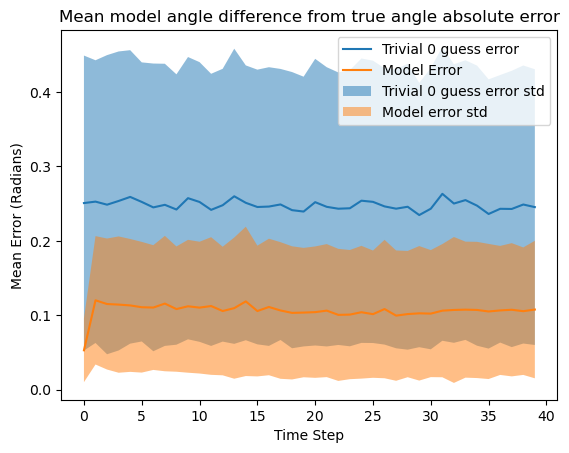

In [36]:
plot_accuracy(angs,dy,y_hat,y)

Mean error:  0.31179535449190626
Mean end error:  0.4380474183524386


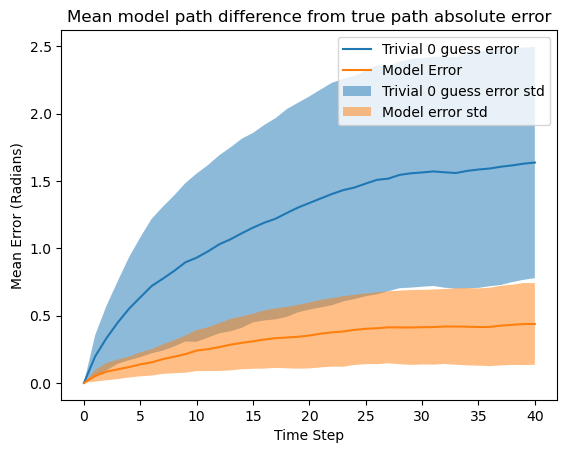

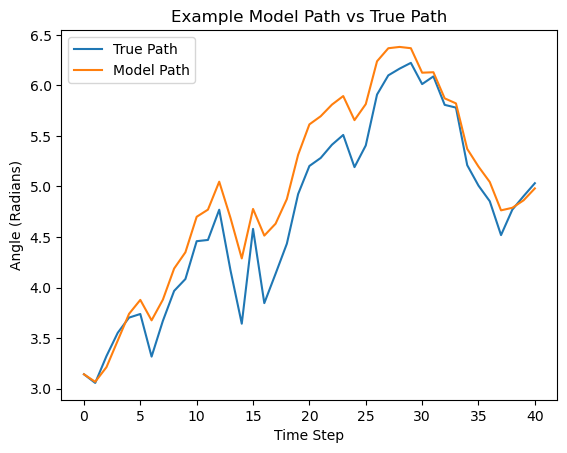

In [37]:
plot_path_accuracy(angs,y,example_path=1)